In [ ]:
!pip install unidecode
import numpy as np
import pandas as pd
import unidecode
import re

from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, TimeDistributed, LSTM, Input
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

     |████████████████████████████████| 245kB 8.1MB/s 


Using TensorFlow backend.


In [ ]:
with open('/content/drive/My Drive/ML_Data/spa.txt', mode='rt', encoding='utf-8') as f:
  text = f.read()

In [ ]:
lines = text.strip().split('\n')
lines = [i.split('\t') for i in lines]
lines = np.array(lines)

In [ ]:
english = []
for i in lines[:, 0]:
  english.append(i)
spanish = []
for i in lines[:, 1]:
  spanish.append(i)

In [ ]:
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = unidecode.unidecode(sentence)
  sentence = re.sub("'", '', sentence)
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  return " ".join(sentence.split())

df = pd.DataFrame({"spanish":spanish, "english": english}) 

df["cleaned_spanish"] = df["spanish"].apply(lambda x : clean_text(x))
df["cleaned_english"] = df["english"].apply(lambda x : clean_text(x))

df.tail()

,spanish,english,cleaned_spanish,cleaned_english
123765,Hay cuatro causas principales de muertes relac...,There are four main causes of alcohol-related ...,hay cuatro causas principales de muertes relac...,there are four main causes of alcohol related ...
123766,Hay madres y padres que se quedan despiertos d...,There are mothers and fathers who will lie awa...,hay madres y padres que se quedan despiertos d...,there are mothers and fathers who will lie awa...
123767,Una huella de carbono es la cantidad de contam...,A carbon footprint is the amount of carbon dio...,una huella de carbono es la cantidad de contam...,a carbon footprint is the amount of carbon dio...
123768,Como suele haber varias páginas web sobre cual...,Since there are usually multiple websites on a...,como suele haber varias paginas web sobre cual...,since there are usually multiple websites on a...
123769,"Si quieres sonar como un hablante nativo, debe...","If you want to sound like a native speaker, yo...",si quieres sonar como un hablante nativo debes...,if you want to sound like a native speaker you...


In [ ]:
spanish_freq = {}

for sent in df["cleaned_spanish"].values:
  for word in sent.split():
    try:
      spanish_freq[word] +=1
    except KeyError:
      spanish_freq[word] = 1

english_freq = {}

for sent in df["cleaned_english"].values:
  for word in sent.split():
    try:
      english_freq[word] += 1
    except KeyError:
      english_freq[word] = 1

In [ ]:
thresold = 2

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, val in english_freq.items():
  tot_cnt += 1
  tot_freq += val

  if(val < thresold):
    cnt += 1
    freq += 1
print("percentage of less frequency words in english doc", cnt/tot_cnt)
print("percentage of contribution of less frequency words in english doc", freq/tot_freq)

percentage of less frequency words in english doc 0.32153927572389807
percentage of contribution of less frequency words in english doc 0.0054589328575645945


In [ ]:
thresold = 2

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, val in spanish_freq.items():
  tot_cnt += 1
  tot_freq += val

  if(val < thresold):
    cnt += 1
    freq += 1
print("percentage of less frequency words in spanish doc", cnt/tot_cnt)
print("percentage of contribution of less frequency words in spanish doc", freq/tot_freq)

percentage of less frequency words in spanish doc 0.4031868088311071
percentage of contribution of less frequency words in spanish doc 0.013557099217921174


In [ ]:
english_vocab = {}

english_corpus = [k for k, v in english_freq.items()]
cnt = 4
for i in english_corpus:
  if(english_freq[i] >= thresold):
    english_vocab[i] = cnt
    cnt += 1

spanish_vocab = {}

spanish_corpus = [k for k, v in spanish_freq.items()]
cnt = 2
for i in spanish_corpus:
  if(spanish_freq[i] >= thresold):
    spanish_vocab[i] = cnt
    cnt += 1

In [ ]:
english_vocab['<pad>'] = 0
english_vocab['<unk>'] = 1
spanish_vocab['<pad>'] = 0
spanish_vocab['<unk>'] = 1


spanish_sentences = []
for i in df["cleaned_spanish"].values:
  sent = []
  for j in i.split():
    if(j not in spanish_corpus):
      sent.append(spanish_vocab['<unk>'])
    elif(spanish_freq[j] < thresold):
      sent.append(spanish_vocab['<unk>'])
    else:
      sent.append(spanish_vocab[j])
  spanish_sentences.append(sent)


english_sentences = []
for i in df["cleaned_english"].values:
  sent = []
  for j in i.split():
    if(j not in english_corpus):
      sent.append(english_vocab['<unk>'])
    elif(english_freq[j] < thresold):
      sent.append(english_vocab['<unk>'])
    else:
      sent.append(english_vocab[j])
  english_sentences.append(sent)


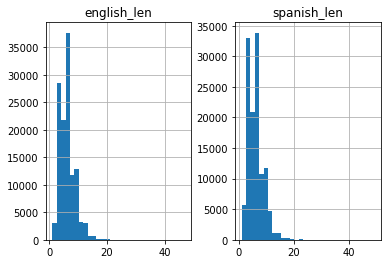

In [ ]:
english_sent_len = []
spanish_sent_len = []

for i in spanish_sentences:
  spanish_sent_len.append(len(i))
for i in english_sentences:
  english_sent_len.append(len(i))

import matplotlib.pyplot as plt
%matplotlib inline

length_df = pd.DataFrame({"english_len":english_sent_len, "spanish_len":spanish_sent_len})

length_df.hist(bins=30)
plt.show()

In [ ]:
spanish_pad_sentences = pad_sequences(spanish_sentences, maxlen=15, padding='post', truncating='post')
english_pad_sentences = pad_sequences(english_sentences, maxlen=15, padding='post', truncating='post')

In [ ]:
english_vocab['<start>'] = 2
english_vocab['<end>'] = 3

tar_sentences = []
for i in english_pad_sentences:
  tar_sentences.append(np.insert(i, 0, english_vocab['<start>']))
target_sentences = []
for i in tar_sentences:
  if(0 in i):
    target_sentences.append(np.insert(i, list(i).index(0), english_vocab['<end>']))
  else:
    target_sentences.append(np.insert(i, len(i), english_vocab['<end>']))
target_sentences = np.array(target_sentences)

target_sentences

array([[   2,    4,    3, ...,    0,    0,    0],
       [   2,    4,    3, ...,    0,    0,    0],
       [   2,    4,    3, ...,    0,    0,    0],
       ...,
       [   2,  120, 8679, ...,  573,  120,    3],
       [   2, 5122,  339, ..., 2710,  735,    3],
       [   2, 1659,  103, ...,  255, 1689,    3]], dtype=int32)

In [ ]:
source_train, source_valid, target_train, target_valid = train_test_split(english_pad_sentences, target_sentences, test_size=0.2, random_state=42)

In [ ]:
max_spa_len = 15
max_eng_len = 17


latent_dim = 150
embedding_dim = 200

x_voc = len(spanish_vocab)
y_voc = len(english_vocab)

In [ ]:
enc_input = Input(shape=(max_spa_len, ))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(enc_input)
enc_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
enc_output, enc_h, enc_c = enc_lstm(enc_emb)

In [ ]:
dec_input = Input(shape=(max_eng_len-1, ))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(dec_input)
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_output, dec_h, dec_c = dec_lstm(dec_emb, initial_state=[enc_h, enc_c])
dec_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
dec_outputs = dec_dense(dec_output)

In [ ]:
model = Model([enc_input, dec_input], dec_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 200)      3011800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 16, 200)      1795600     input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.0001)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([source_train, target_train[:,:-1]], target_train.reshape(target_train.shape[0], target_train.shape[1], 1)[:, 1:], 
          epochs=100, batch_size=512, callbacks=[es, mc], validation_data=([source_valid, target_valid[:, :-1]], target_valid.reshape(target_valid.shape[0], target_valid.shape[1], 1)[:,1:]))

In [ ]:
model = load_model('best_model.h5')
model.save_weights('best_model_weights.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
reverse_source_index = dict((val, key) for key, val in spanish_vocab.items())
reverse_target_index = dict((val, key) for key, val in english_vocab.items())

In [ ]:
encoder_model = Model(inputs=enc_input, outputs=[enc_output, enc_h, enc_c])

decoder_state_h = Input(shape=(latent_dim, ))
decoder_state_c = Input(shape=(latent_dim, ))

decoder_input = Input(shape=(None, ))
decoder_emb = dec_emb_layer(decoder_input)

decoder_output , decoder_h, decoder_c = dec_lstm(decoder_emb, initial_state=[decoder_state_h, decoder_state_c])

decoder_output = dec_dense(decoder_output)

decoder_model = Model(
    [decoder_input] + [decoder_state_h, decoder_state_c],
    [decoder_output] + [decoder_h, decoder_c]
)

In [ ]:
def predict_sentence(input_seq):

  e_output, h, c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = english_vocab['<start>']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:

    d_output, d_h, d_c = decoder_model.predict([target_seq] + [h, c])

    sample_token_index = np.argmax(d_output[0, -1, :])
    sample_token = reverse_target_index[sample_token_index]

    if(sample_token != '<end>'):
      decoded_sentence = decoded_sentence + sample_token + " "
    
    if(sample_token == '<end>' or (len(decoded_sentence.split()) >= max_eng_len-1)):
      stop_condition = True

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sample_token_index

    h, c = d_h, d_c

  return decoded_sentence.strip()


In [ ]:
source = []
for i in source_valid[1000:1050]:
  s= ''
  for j in i:
    if( j != 0 ):
      s = s + reverse_source_index[j] + ' '
  source.append(s)

source = np.array(source)

target = []
for i in target_valid[1000: 1050]:
  s=''
  for j in i:
    if((j != 0) and (j != 2) and (j!= 3)):
      s = s + reverse_target_index[j] + ' '
  target.append(s)

target = np.array(target)

In [ ]:
final = pd.DataFrame({"source": source, "target":target})

predicted = []
for i in source_valid[1000:1050]:
  predicted.append(predict_sentence(i.reshape(1, max_spa_len)))

final["predicted"] = predicted

final.head()

,source,target,predicted
0,es los grima gota corri,please do something about it,please do something about it
1,perdio pruebalo dispare,are you lost,are you lost
2,entendiste saludo jugaba hara,tom often breaks promises,tom often breaks promises
3,ayuda baja lee prueba,i disagree with that,i disagree with that
4,amable traed dijo se odia salga perdi,the rain kept us from going out,the rain almost made is snowing until


In [ ]:
final

,source,target,predicted
0,es los grima gota corri,please do something about it,please do something about it
1,perdio pruebalo dispare,are you lost,are you lost
2,entendiste saludo jugaba hara,tom often breaks promises,tom often breaks promises
3,ayuda baja lee prueba,i disagree with that,i disagree with that
4,amable traed dijo se odia salga perdi,the rain kept us from going out,the rain almost made is snowing until
5,entendiste tonto problemas platos quedar,tom couldnt understand marys joke,tom couldnt understand marys joke
6,entendiste leed para ignoraron gane preocupart...,tom has no intention of apologizing to mary,tom has no intention of mary committed anything
7,levanta prometisteis incendio,im catching on,im catching on
8,llamenlo los pruebalo cogerlo hablo tome,what do you want to buy,what do you want to buy
9,entendiste hay sea pensar,tom is a creep,tom is a creep
